<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#setup" data-toc-modified-id="setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#data" data-toc-modified-id="data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>data</a></span></li></ul></div>

# setup

In [1]:
import datetime
import gc
import json
import os
import pprint
import sys
import warnings
from io import BytesIO

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import folium
import geopandas as gpd
import h5py
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import optuna
import pandas as pd
import psutil
import seaborn as sns
import torch
import torch.cuda.amp as amp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import tqdm
from folium.plugins import HeatMap
from IPython.display import display
from scipy.interpolate import griddata
from selenium import webdriver
from skimage.transform import resize
from sklearn.metrics import mean_squared_error, r2_score, brier_score_loss, balanced_accuracy_score, f1_score
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
print(os.uname())
print("Cores: ", os.cpu_count())
print("Memory: ", round(psutil.virtual_memory().total / 1024 / 1024 / 1024, 2), "GB")
print()
print(sys.version)
print(sys.version_info)
print()
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

posix.uname_result(sysname='Linux', nodename='u22', release='6.2.0-36-generic', version='#37~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Oct  9 15:34:04 UTC 2', machine='x86_64')
Cores:  16
Memory:  15.54 GB

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)

2.0.0+cu117
11.7
8500
NVIDIA GeForce GTX 1660 Ti
True


In [3]:
sns.set_style("whitegrid")

plt.rcParams.update({
    'font.size'       : 9,
    'figure.figsize'  : (3.5, 2.8),
    'figure.dpi'      : 300,
    'savefig.dpi'     : 300,
    'text.usetex'     : True,
    'font.family'     : 'serif',
    'font.serif'      : ['Times New Roman'],
    'axes.labelsize'  : 9,
    'axes.titlesize'  : 9,
    'xtick.labelsize' : 8,
    'ytick.labelsize' : 8,
    'legend.fontsize' : 8,
    'lines.linewidth' : 1,
    'axes.linewidth'  : 1,
    'grid.linestyle'  : '--',
    'grid.linewidth'  : 0.5,
    'grid.alpha'      : 0.8,
})

sns.set_context(
    "paper", 
    rc={
        "font.size"      : 9,
        "axes.titlesize" : 9,
        "axes.labelsize" : 9, 
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    }
)

In [4]:
experiment_name = "wildfire_spread"
folder_path = f"../data/08_reporting/{experiment_name}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

golden_ratio = (np.sqrt(5) - 1) / 2

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [5]:
BRAZIL_EXTENT = [-74, -34, -34, 6]
SAO_PAULO_EXTENT = [-53, -44, -25, -20]

In [6]:
MAX_LAT = 32.99499999641088
MIN_LAT = -55.98500000358912
MAX_LON = -33.009801806103724
MIN_LON = -119.98980180610373

MAX_LAT = BRAZIL_EXTENT[3]
MIN_LAT = BRAZIL_EXTENT[2]
MAX_LON = BRAZIL_EXTENT[1]
MIN_LON = BRAZIL_EXTENT[0]

# data

In [7]:
DATA = torch.load(f"../data/02_intermediate/wildfire_spread/wildfire_spread_tensor.pt").to(torch.float32) 

In [8]:
DATA.shape

torch.Size([37, 5, 300, 300])

In [9]:
TARGET = DATA[:, 0, :, :]
FEATURES = DATA[:, 1:, :, :]

print("DATA")
print(TARGET.shape)
print(FEATURES.shape)

X_train, X_test, y_train, y_test = train_test_split(
    FEATURES, TARGET, test_size=0.3, random_state=1
)

print()
print("TRAIN")
print(X_train.shape)
print(y_train.shape)
print("TEST")
print(X_test.shape)
print(y_test.shape)


DATA
torch.Size([37, 300, 300])
torch.Size([37, 4, 300, 300])

TRAIN
torch.Size([25, 4, 300, 300])
torch.Size([25, 300, 300])
TEST
torch.Size([12, 4, 300, 300])
torch.Size([12, 300, 300])


In [10]:
for i in range(0, 4):
    print(f"Layer {i}")
    print(f"Max: {torch.max(X_train[:, i, :, :])}")
    print(f"Min: {torch.min(X_train[:, i, :, :])}")
    print()

print(30*"= ")
print()

for i in range(0, 1):
    print(f"Target {i}")
    print(f"Max: {torch.max(y_train[i, :, :])}")
    print(f"Min: {torch.min(y_train[i, :, :])}")

Layer 0
Max: 765.0
Min: 0.0

Layer 1
Max: 765.0
Min: 0.0

Layer 2
Max: 765.0
Min: 15.0

Layer 3
Max: 765.0
Min: 0.0

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

Target 0
Max: 1.0
Min: 0.0


In [11]:
mean = X_train.mean(dim=(0, 2, 3), keepdim=True)
std = X_train.std(dim=(0, 2, 3), keepdim=True)

mean = mean.view(1, -1, 1, 1)
std = std.view(1, -1, 1, 1)

# _min = X_train.min(dim=(0, 2, 3), keepdim=True)[0]
# _max = X_train.max(dim=(0, 2, 3), keepdim=True)[0]

# _min = _min.view(1, -1, 1, 1)
# _max = _max.view(1, -1, 1, 1)

normed_X_train = (X_train - mean) / std
normed_X_test = (X_test - mean) / std

In [12]:
for i in range(0, 4):
    print(f"Layer {i}")
    print(f"Max: {torch.max(normed_X_train[:, i, :, :])}")
    print(f"Min: {torch.min(normed_X_train[:, i, :, :])}")
    print()

print(30*"= ")
print()

for i in range(0, 1):
    print(f"Target {i}")
    print(f"Max: {torch.max(y_train[i, :, :])}")
    print(f"Min: {torch.min(y_train[i, :, :])}")

Layer 0
Max: 0.9625520706176758
Min: -1.1401420831680298

Layer 1
Max: 0.8304380178451538
Min: -2.137911319732666

Layer 2
Max: 1.0188541412353516
Min: -2.7089486122131348

Layer 3
Max: 0.9022865295410156
Min: -3.868579864501953

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

Target 0
Max: 1.0
Min: 0.0


considering temporal chain of events:

In [13]:
def prepare_data(X, n_days):
    """
    prepare_data
    """
    _X = list()
    for i in range(len(X) - n_days + 1):
        _X.append(X[i:i + n_days])
    return torch.stack(_X)

chain_X_train = prepare_data(normed_X_train, 7)
chain_X_test = prepare_data(normed_X_test, 7)

In [14]:
print(chain_X_train.shape)
print(chain_X_test.shape)

torch.Size([19, 7, 4, 300, 300])
torch.Size([6, 7, 4, 300, 300])


In [15]:
train_loader = DataLoader(
    list(zip(chain_X_train, y_train)),
    batch_size=1,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

test_loader = DataLoader(
    list(zip(chain_X_test, y_test)),
    batch_size=1,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
)

# architecture

In [39]:
class WildfirePredictor(nn.Module):
    # def __init__(self):
    def __init__(self, input_channels=4, conv1_channels=3, conv2_channels=1, lstm_hidden_size=32, output_size=(300, 300)):
        super(WildfirePredictor, self).__init__()
        self.input_channels = input_channels
        self.conv1_channels = conv1_channels
        self.conv2_channels = conv2_channels
        self.lstm_hidden_size = lstm_hidden_size
        self.output_size = output_size
        conv_output_dim = (output_size[0] // 4, output_size[1] // 4)
        
        # self.conv1 = nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1)
        # self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        # self.lstm = nn.LSTM(input_size=16 * 75 * 75, hidden_size=512, batch_first=True)
        # self.fc = nn.Linear(512, 300 * 300)
        self.conv1 = nn.Conv2d(input_channels, conv1_channels, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(conv1_channels, conv2_channels, kernel_size=3, stride=2, padding=1)
        self.lstm = nn.LSTM(input_size=conv2_channels * conv_output_dim[0] * conv_output_dim[1], hidden_size=lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, output_size[0] * output_size[1])

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()

        processed_steps = []
        for i in range(timesteps):
            step = F.relu(self.conv1(x[:, i]))
            step = F.relu(self.conv2(step))
            step = step.view(batch_size, -1)
            processed_steps.append(step)

        lstm_input = torch.stack(processed_steps, dim=1)
        lstm_out, (h_n, c_n) = self.lstm(lstm_input)
        
        out = self.fc(lstm_out[:, -1])
        out = out.view(batch_size, 300, 300)
        out = torch.sigmoid(out)
        return out



In [40]:
model = WildfirePredictor()
model.to(torch.float32) # model.to(torch.float16) 
model.to(device)
model 

WildfirePredictor(
  (conv1): Conv2d(4, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(3, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lstm): LSTM(5625, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=90000, bias=True)
)

In [41]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training

In [42]:
def train(epoch, model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.float().to(device), target.float().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.view(-1, 300, 300))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Train Epoch: {epoch} \tLoss: {total_loss / len(train_loader)}')
    return total_loss / len(train_loader)


In [43]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.float().to(device), target.float().to(device)
            output = model(data)
            test_loss += criterion(output, target.view(-1, 300, 300)).item()
    test_loss /= len(test_loader)
    print(f'Test set: Average loss: {test_loss:.4f}')
    return test_loss

In [44]:
LOSS = dict(
    train=[],
    test=[],
)
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    train_loss = train(epoch, model, train_loader, criterion, optimizer)
    test_loss = test(model, test_loader, criterion)
    LOSS["train"].append(train_loss)
    LOSS["test"].append(test_loss)

Train Epoch: 1 	Loss: 0.6292070715050948
Test set: Average loss: 0.5169
Train Epoch: 2 	Loss: 0.4232880175113678
Test set: Average loss: 0.3479
Train Epoch: 3 	Loss: 0.2900225724044599
Test set: Average loss: 0.2570
Train Epoch: 4 	Loss: 0.21903943152804123
Test set: Average loss: 0.2093
Train Epoch: 5 	Loss: 0.1801493724710063
Test set: Average loss: 0.1824
Train Epoch: 6 	Loss: 0.15684504885422557
Test set: Average loss: 0.1658
Train Epoch: 7 	Loss: 0.14183677183954338
Test set: Average loss: 0.1548
Train Epoch: 8 	Loss: 0.1314798346475551
Test set: Average loss: 0.1472
Train Epoch: 9 	Loss: 0.12391804393969084
Test set: Average loss: 0.1418
Train Epoch: 10 	Loss: 0.11820893303344124
Test set: Average loss: 0.1376
Train Epoch: 11 	Loss: 0.11391883853234742
Test set: Average loss: 0.1345
Train Epoch: 12 	Loss: 0.11048988409732517
Test set: Average loss: 0.1322
Train Epoch: 13 	Loss: 0.1076395919448451
Test set: Average loss: 0.1301
Train Epoch: 14 	Loss: 0.10540158340805456
Test set: 

In [45]:
# fig, ax = plt.subplots()
# ax.plot(LOSS["train"], label="Train")
# ax.plot(LOSS["test"], label="Test")
# ax.set_xlabel("Epoch")
# ax.set_ylabel("Loss")
# ax.legend()
# fig.tight_layout()
# fig.savefig(f"{folder_path}/loss.png", dpi=300)

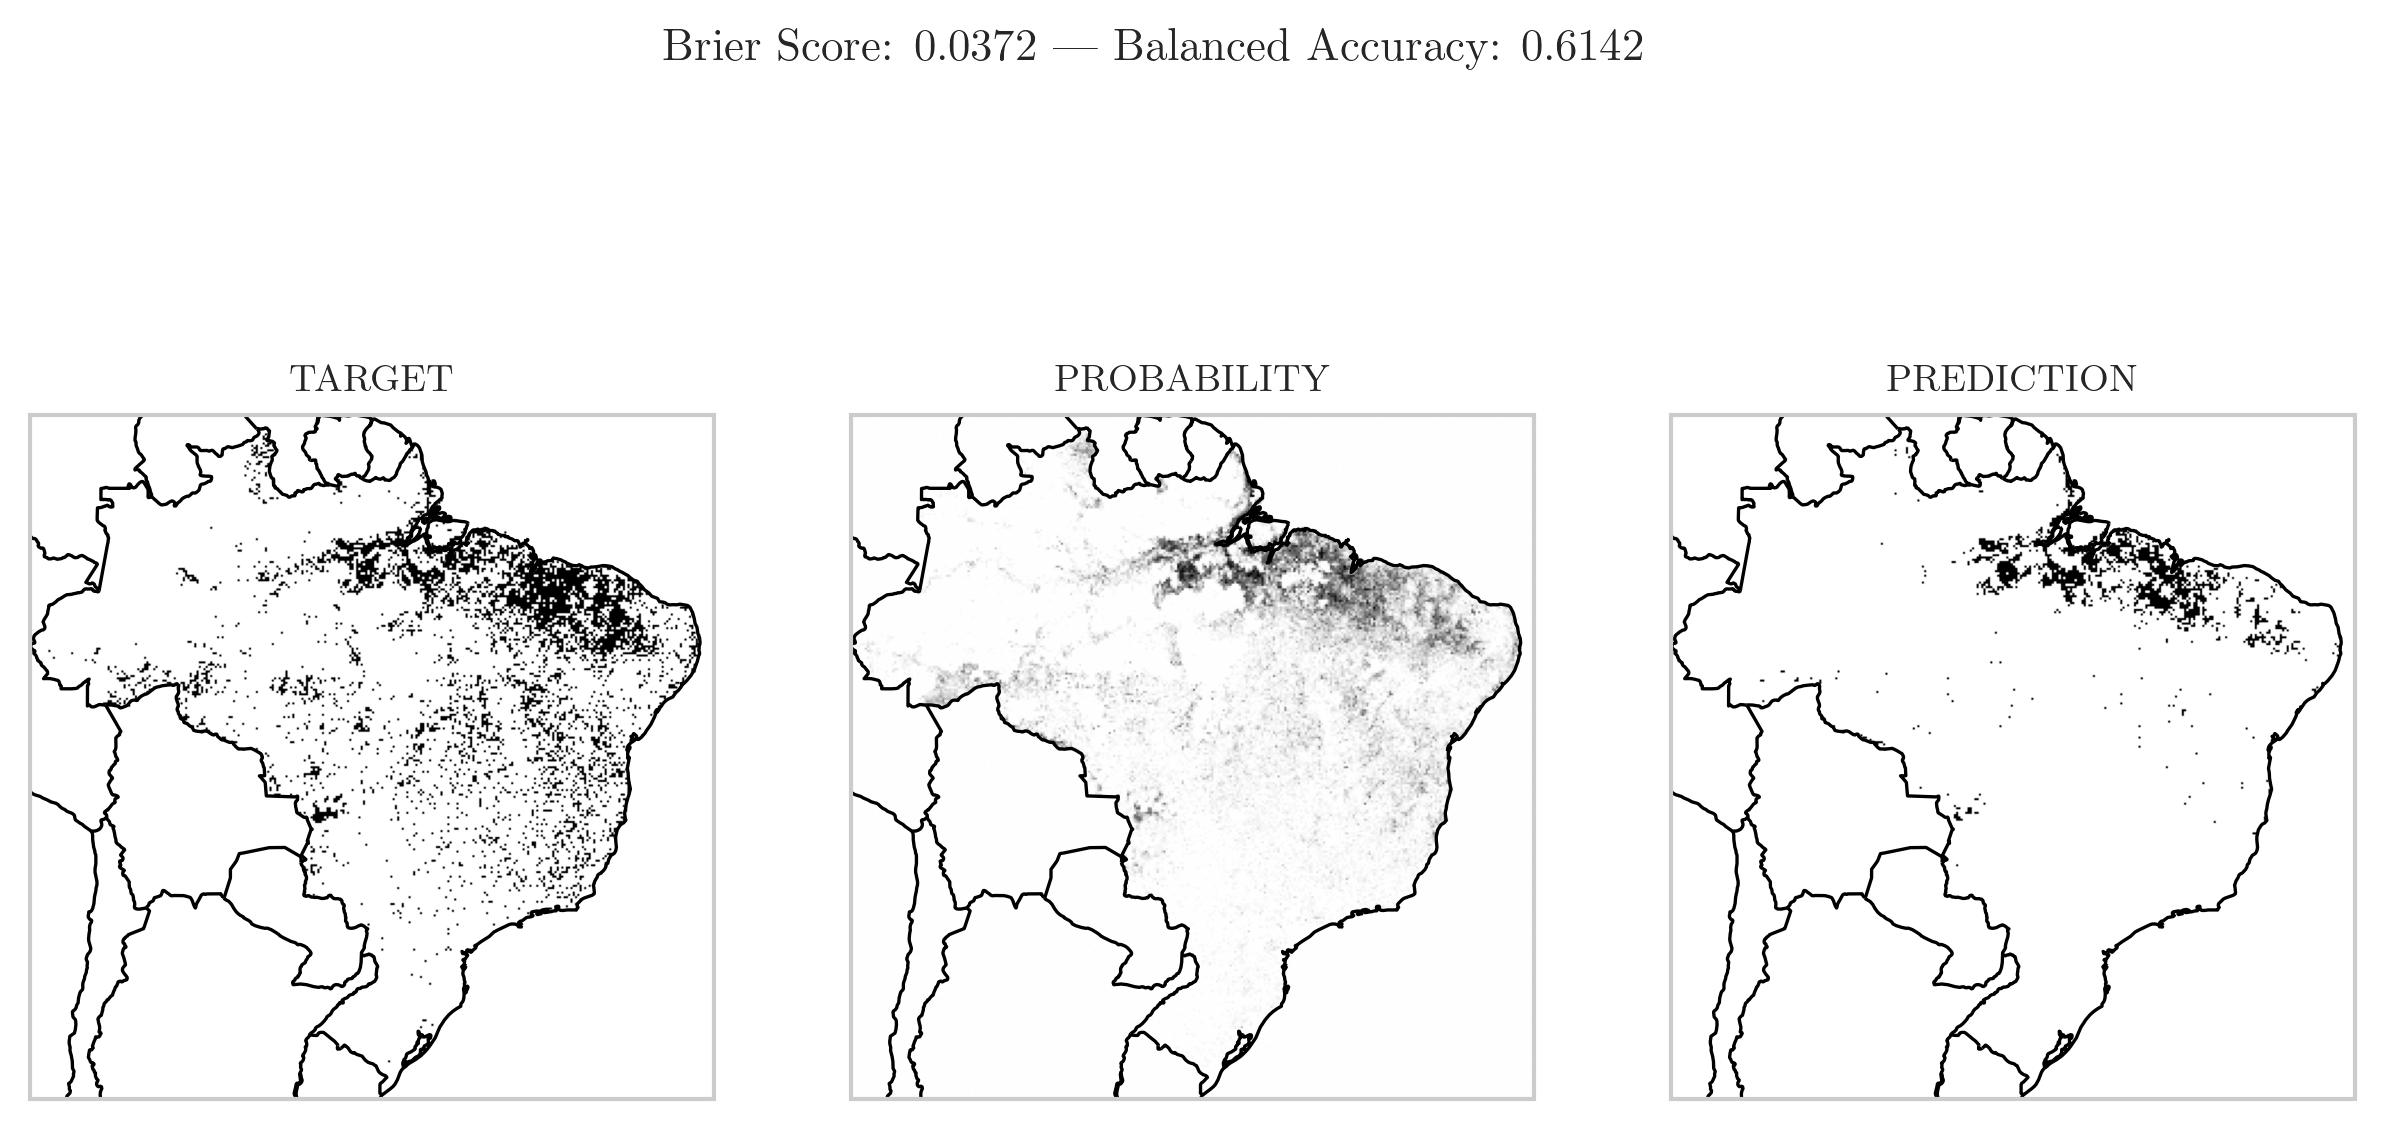

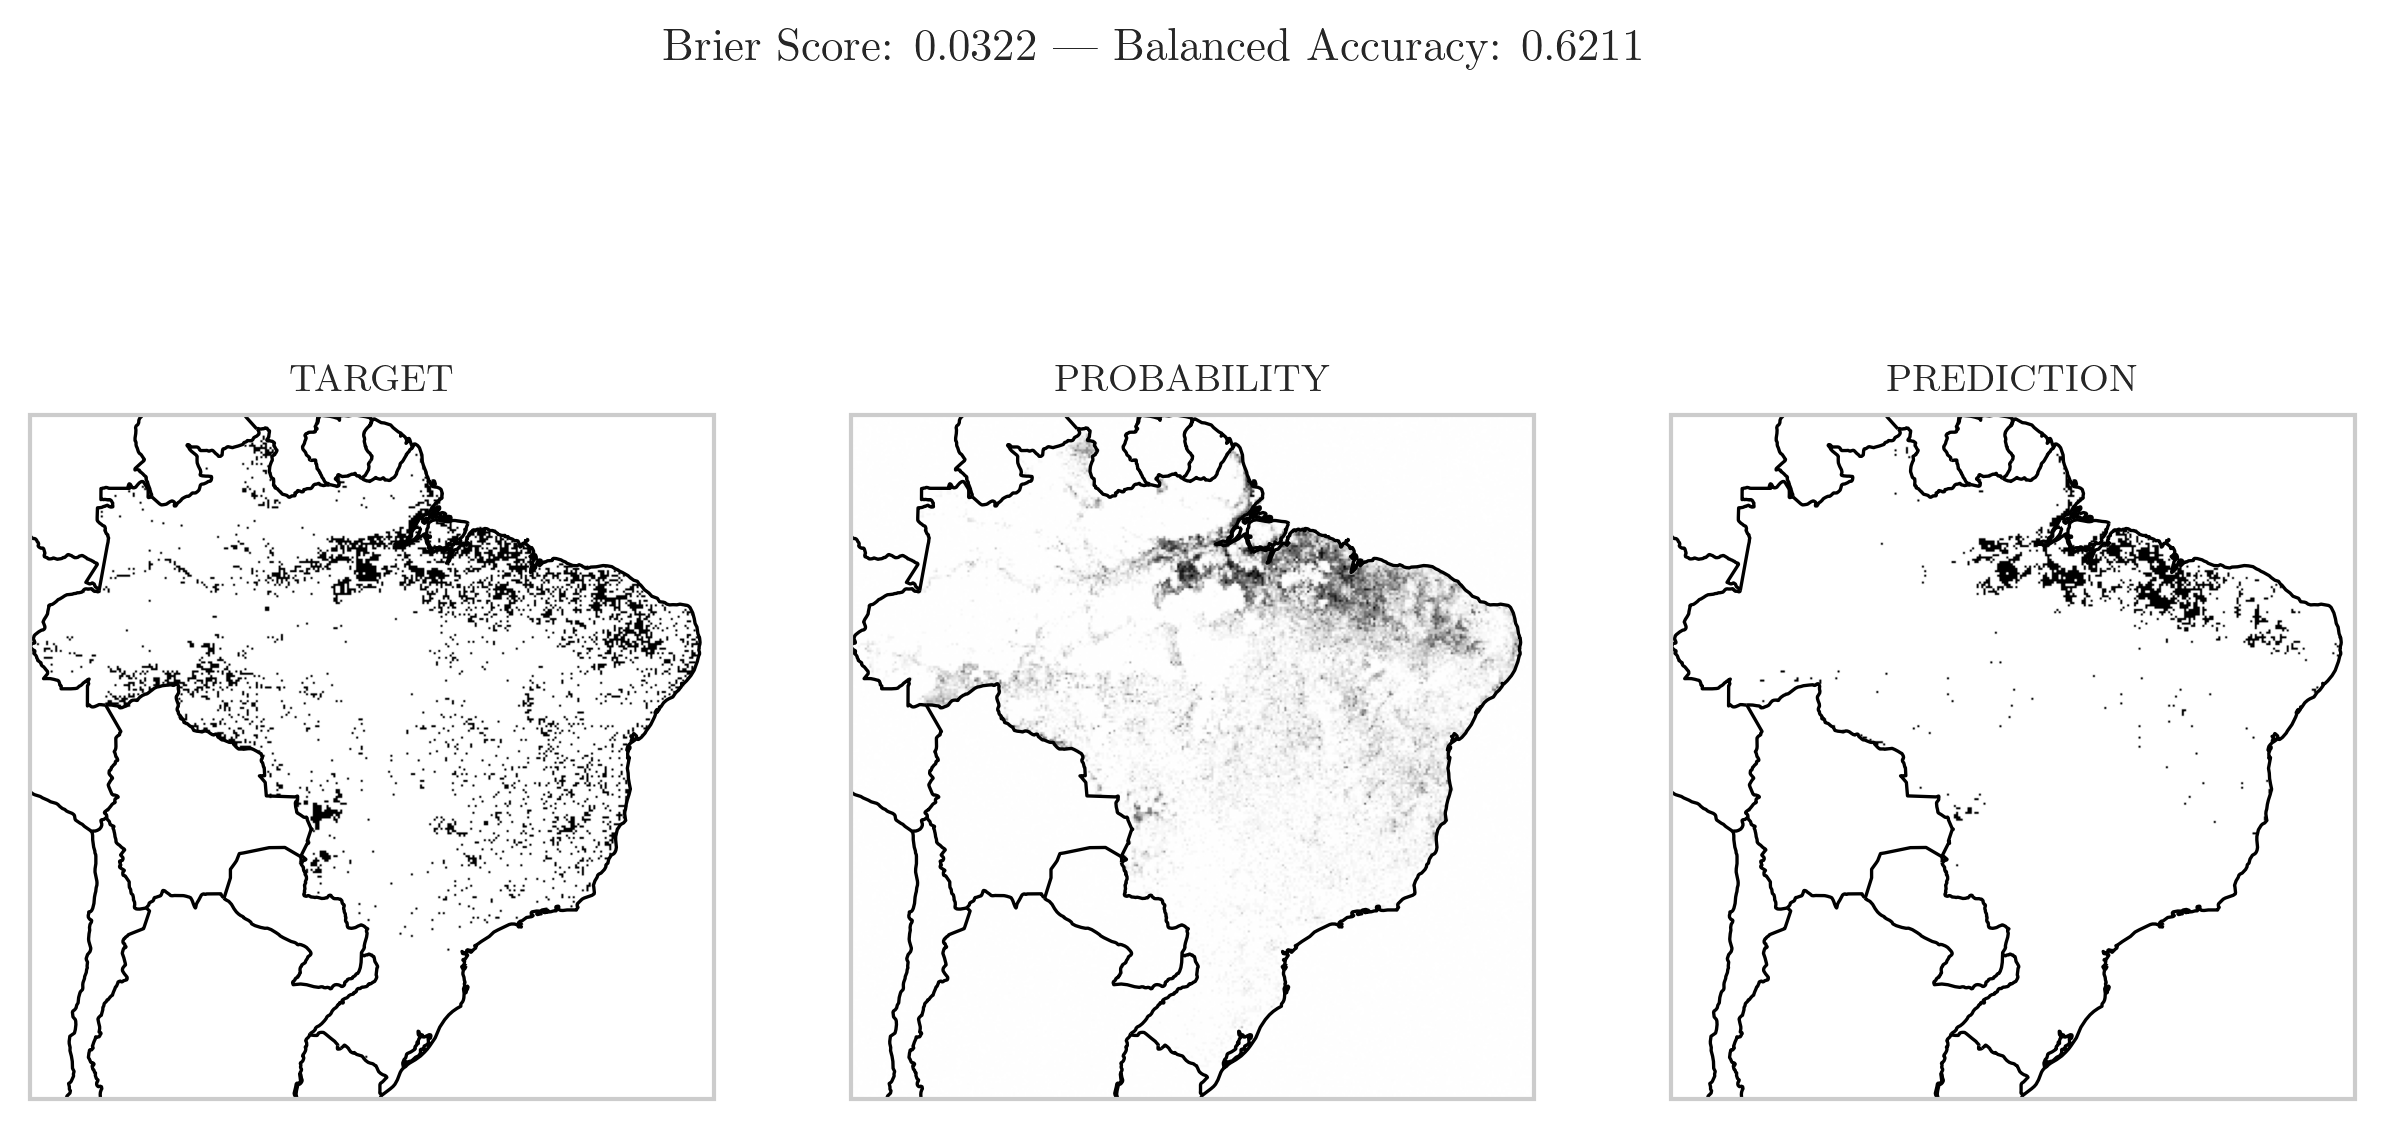

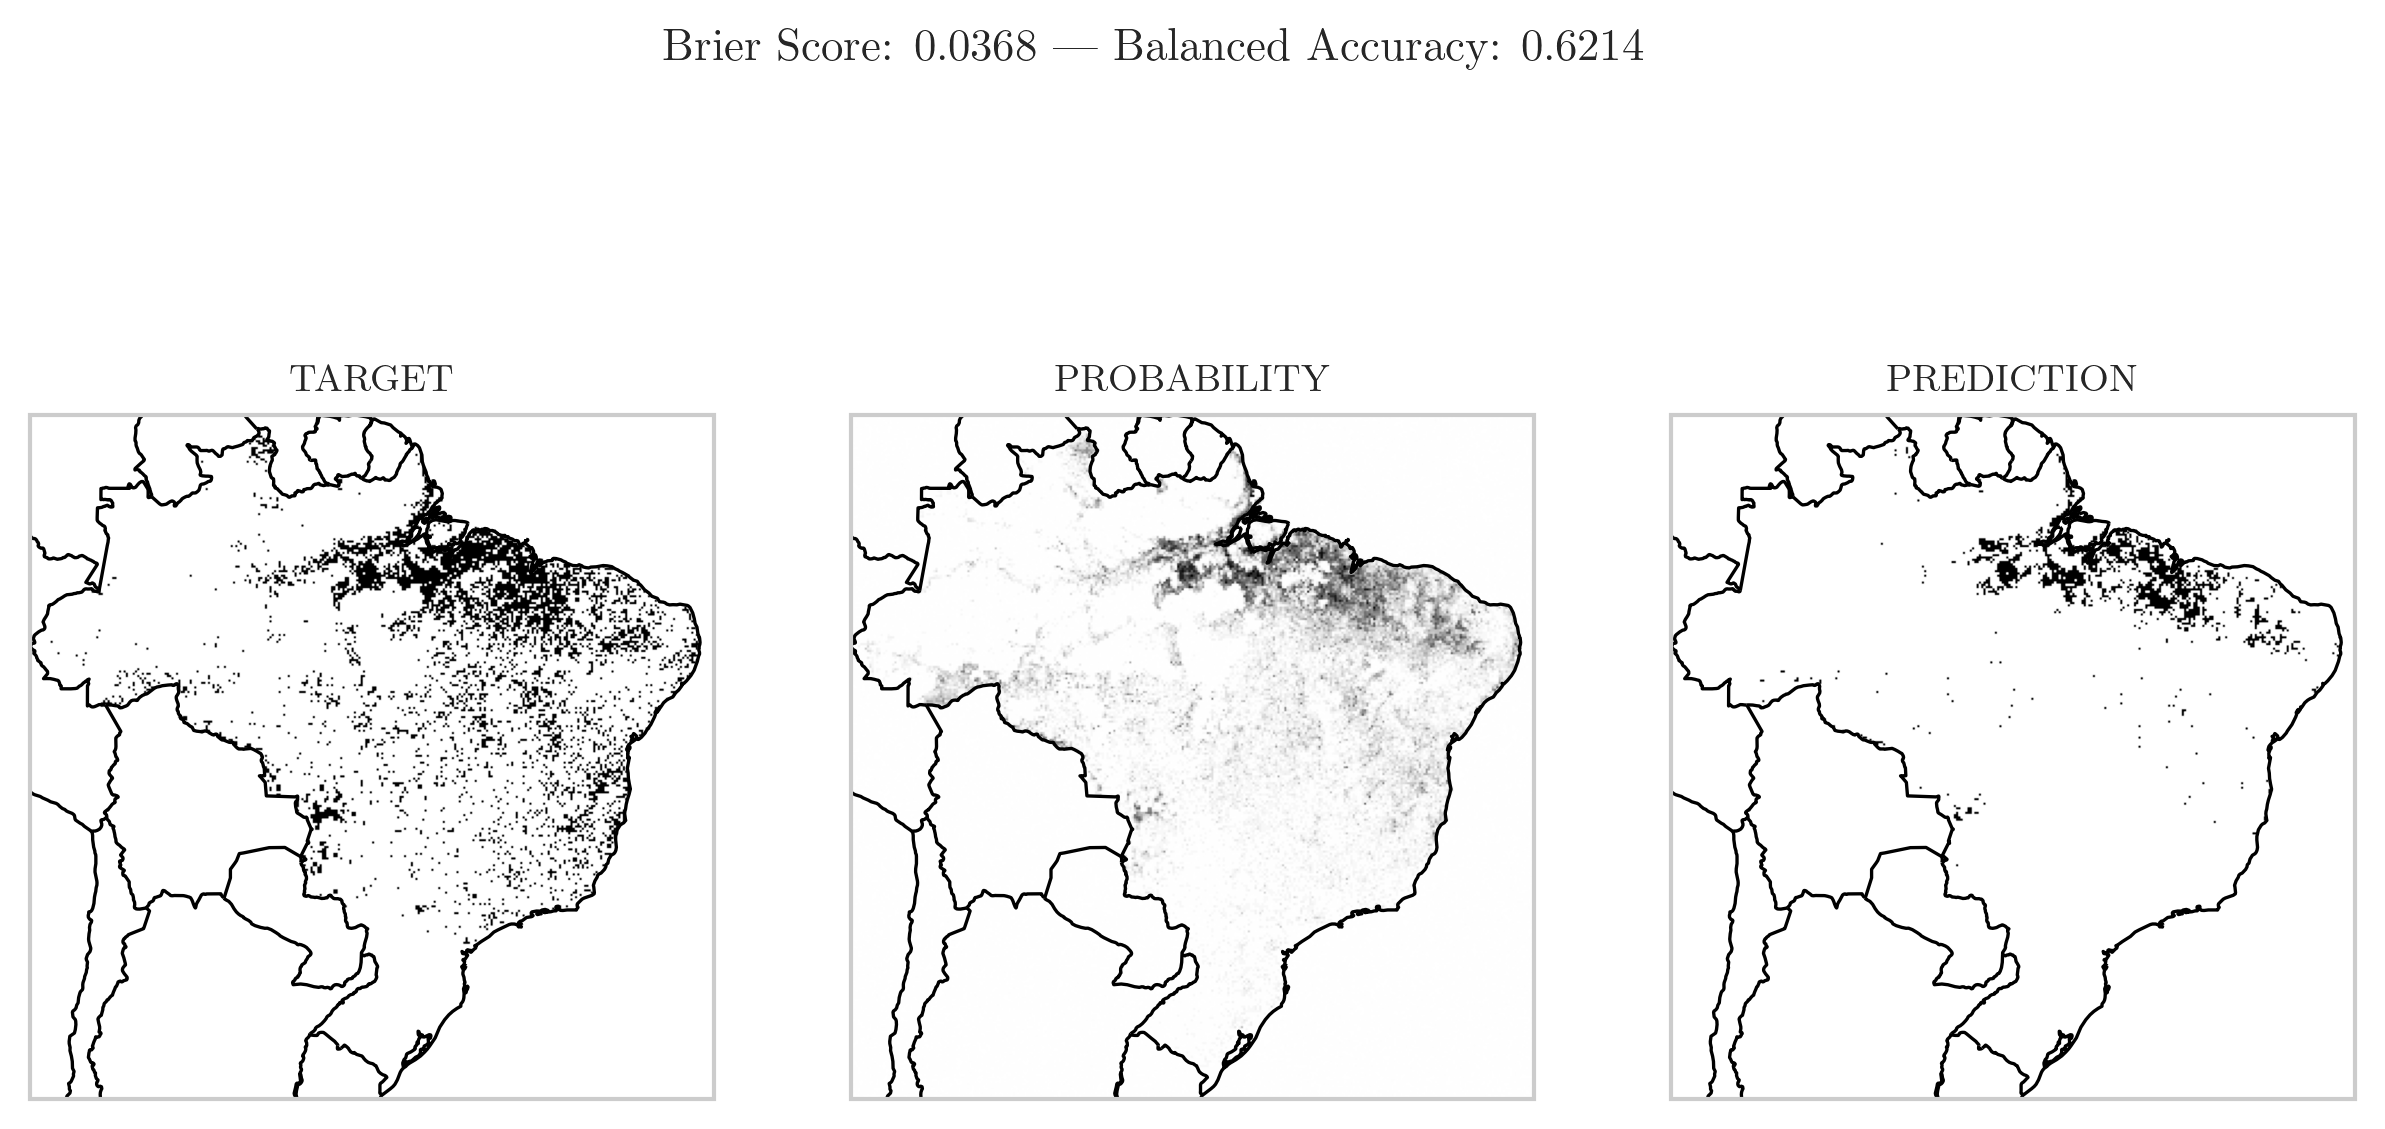

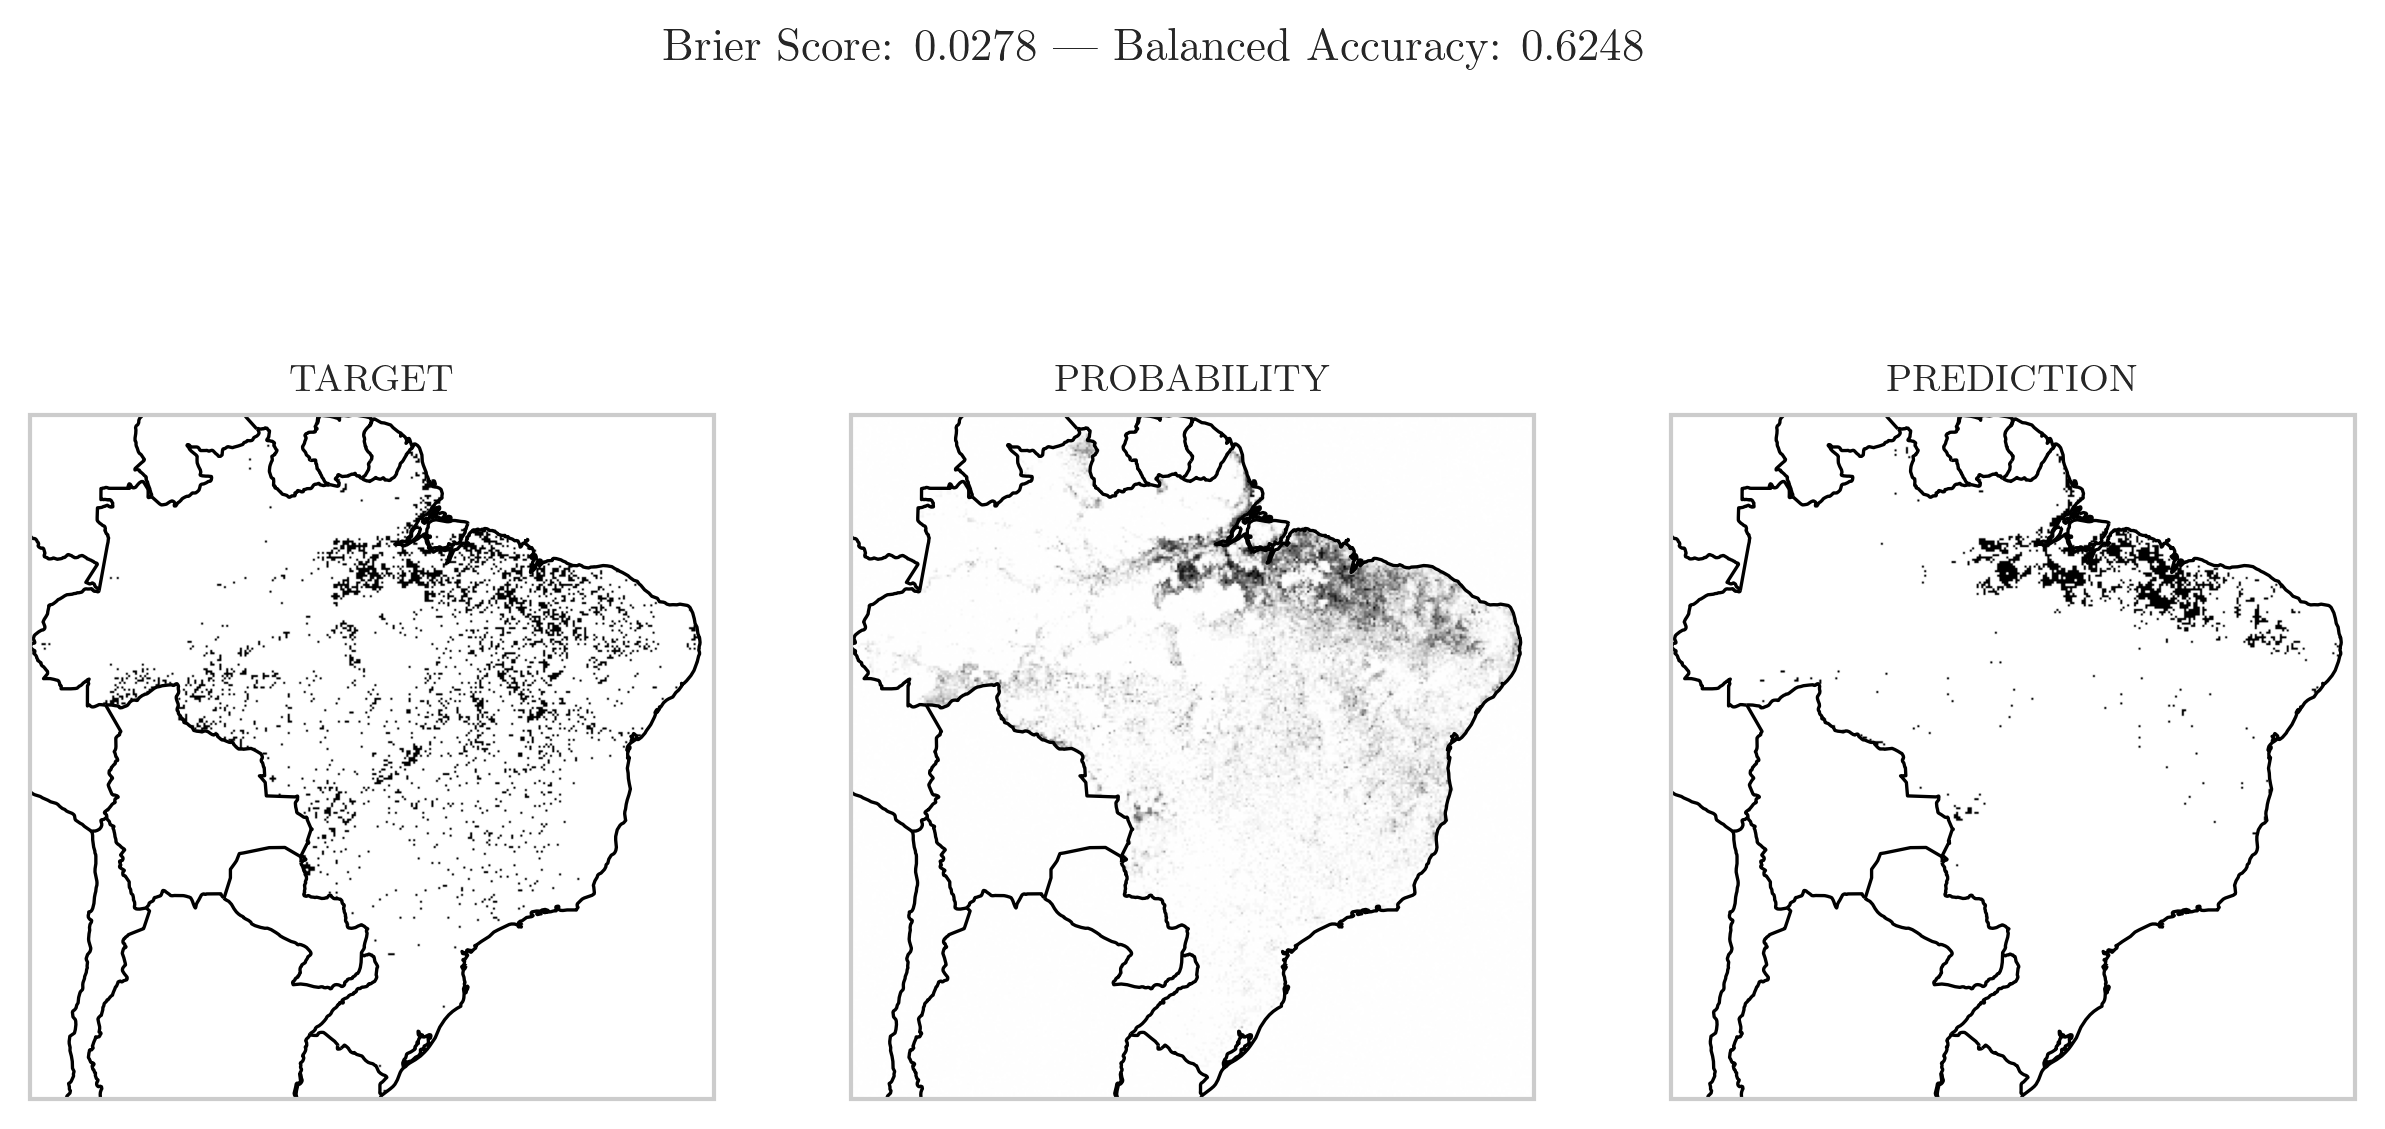

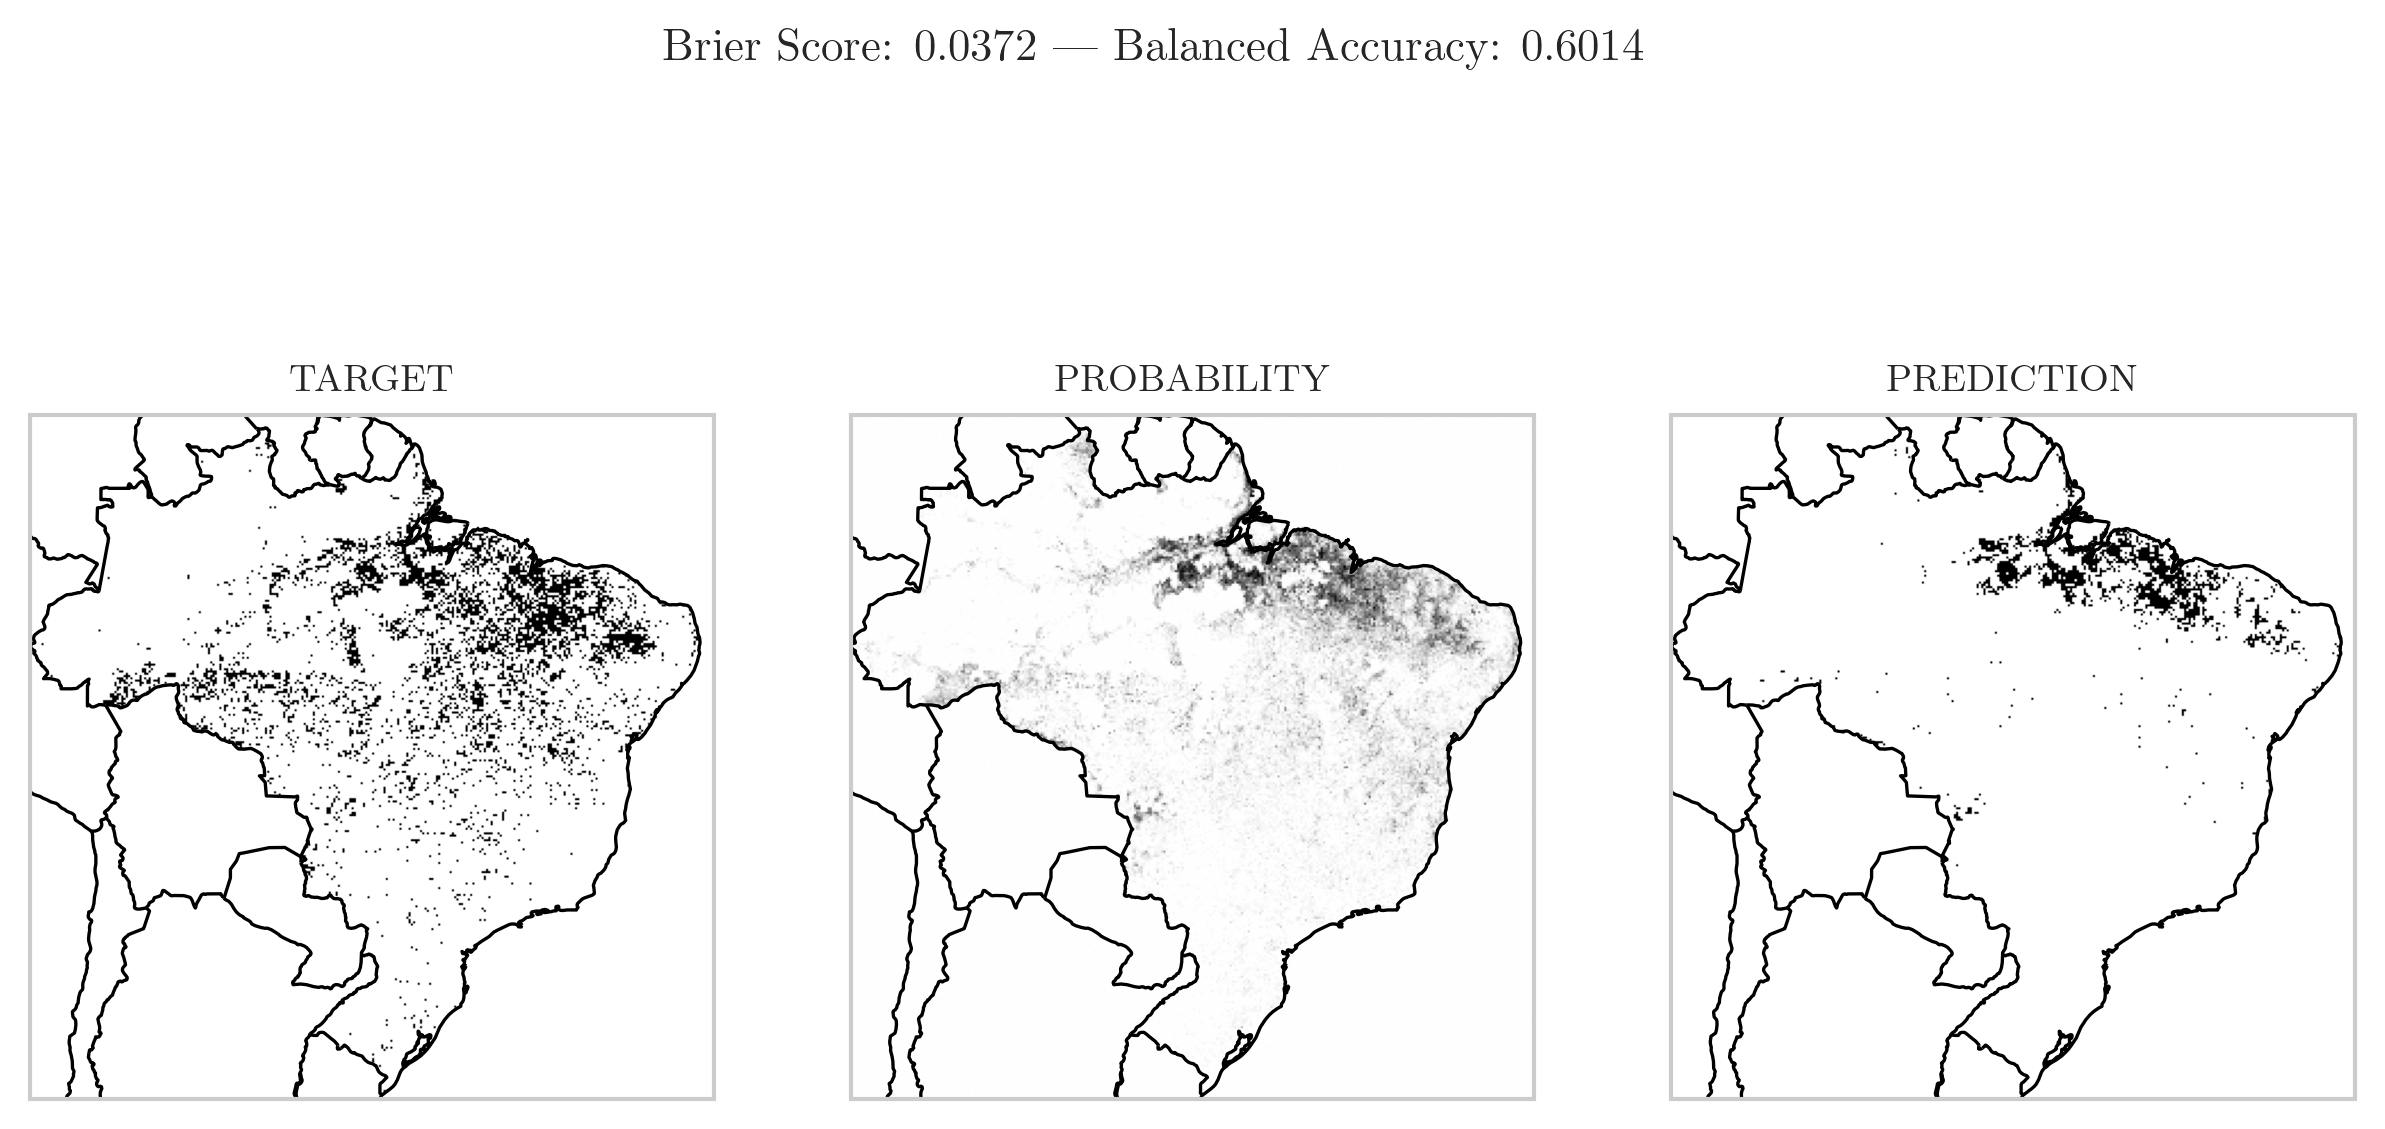

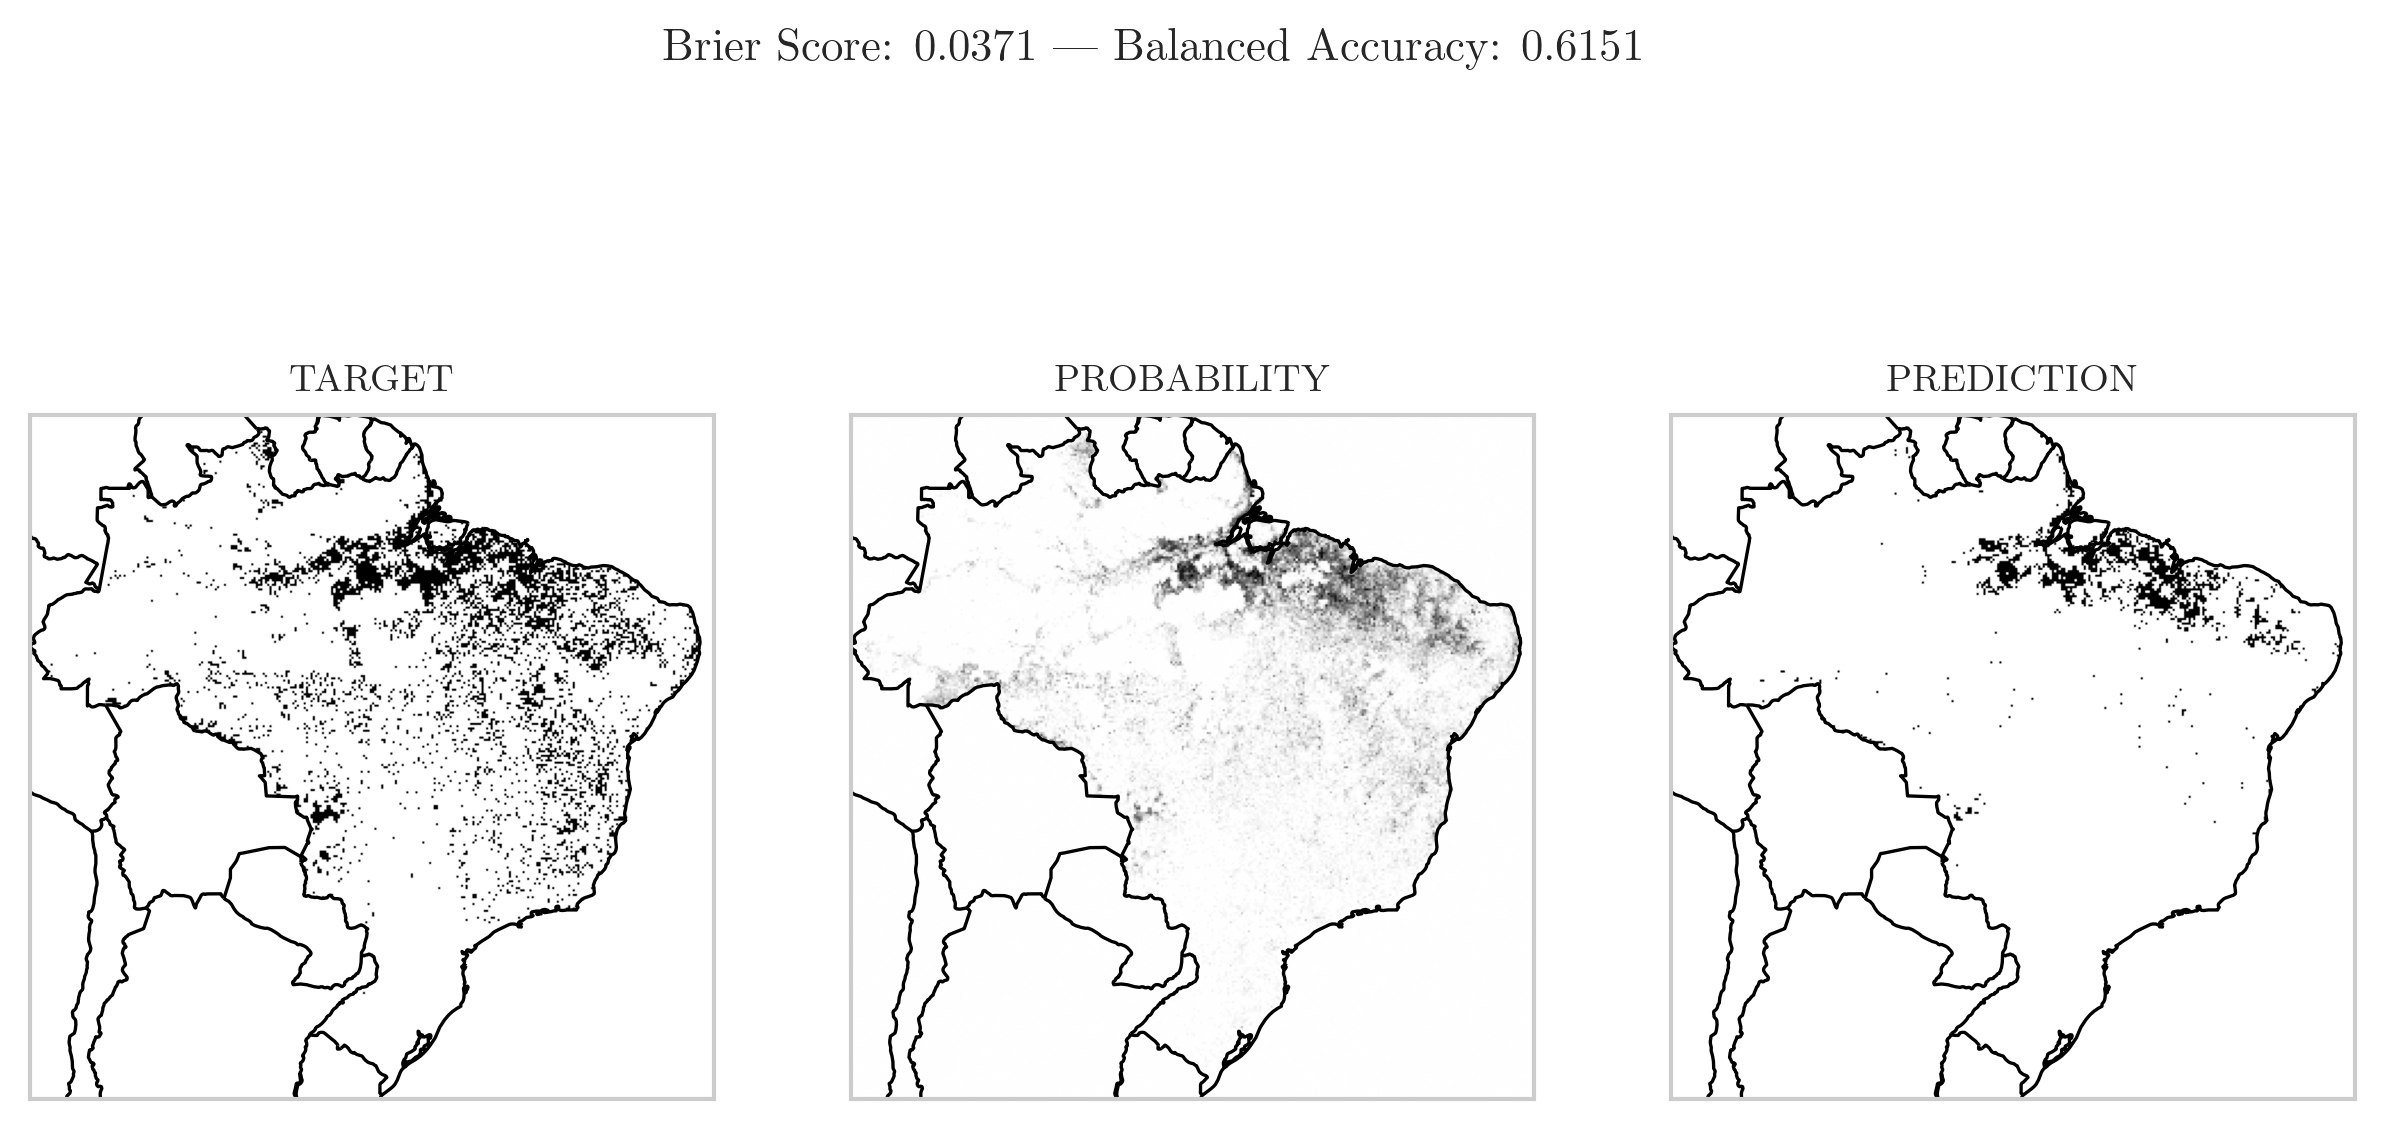

In [46]:
BRIER = list()
BAL_ACC = list()

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.float().to(device), target.float().to(device)
        output = model(data)

        # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))

        ax1.set_extent(BRAZIL_EXTENT, crs=ccrs.PlateCarree())
        ax2.set_extent(BRAZIL_EXTENT, crs=ccrs.PlateCarree())
        ax3.set_extent(BRAZIL_EXTENT, crs=ccrs.PlateCarree())

        ax1.add_feature(cfeature.COASTLINE)
        ax1.add_feature(cfeature.BORDERS)
        ax2.add_feature(cfeature.COASTLINE)
        ax2.add_feature(cfeature.BORDERS)
        ax3.add_feature(cfeature.COASTLINE)
        ax3.add_feature(cfeature.BORDERS)

        ax1.set_title("TARGET")
        ax2.set_title("PROBABILITY")
        ax3.set_title("PREDICTION")

        target_data = target[0]
        ax1.imshow(
            target_data, 
            extent=BRAZIL_EXTENT, cmap='Greys',
            transform=ccrs.PlateCarree()
        )

        output_data = output[0]
        ax2.imshow(
            output_data, 
            extent=BRAZIL_EXTENT, cmap='Greys',
            transform=ccrs.PlateCarree()
        )

        ax3.imshow(
            np.where(output_data > 0.5, 1, 0),
            extent=BRAZIL_EXTENT, cmap='Greys',
            transform=ccrs.PlateCarree()
        )

        _brier = brier_score_loss(target_data.flatten(), output_data.flatten())
        BRIER.append(_brier)

        _bal_acc = balanced_accuracy_score(target_data.flatten(), np.where(output_data > 0.5, 1, 0).flatten())
        BAL_ACC.append(_bal_acc)

        plt.suptitle(f"Brier Score: {_brier:.4f} | Balanced Accuracy: {_bal_acc:.4f}")

In [47]:
# num_epochs = 30
print(model)
print(f"Brier Score: {np.mean(BRIER):.4f}")
print(f"Balanced Accuracy: {np.mean(BAL_ACC):.4f}")

WildfirePredictor(
  (conv1): Conv2d(4, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(3, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lstm): LSTM(5625, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=90000, bias=True)
)
Brier Score: 0.0347
Balanced Accuracy: 0.6163


In [38]:
# num_epochs = 30
print(model)
print(f"Brier Score: {np.mean(BRIER):.4f}")
print(f"Balanced Accuracy: {np.mean(BAL_ACC):.4f}")

WildfirePredictor(
  (conv1): Conv2d(4, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(3, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lstm): LSTM(11250, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=90000, bias=True)
)
Brier Score: 0.0347
Balanced Accuracy: 0.6165


In [24]:
# num_epochs = 10
print(model)
print(f"Brier Score: {np.mean(BRIER):.4f}")
print(f"Balanced Accuracy: {np.mean(BAL_ACC):.4f}")

WildfirePredictor(
  (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lstm): LSTM(90000, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=90000, bias=True)
)
Brier Score: 0.0660
Balanced Accuracy: 0.6169


In [71]:
# num_epochs = 100
print(model)
print(f"Brier Score: {np.mean(BRIER):.4f}")
print(f"Balanced Accuracy: {np.mean(BAL_ACC):.4f}")

WildfirePredictor(
  (conv1): Conv2d(4, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (lstm): LSTM(67500, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=90000, bias=True)
)
Brier Score: 0.0347
Balanced Accuracy: 0.6163


<br/><br/><br/><br/><br/>

In [48]:
gc.collect()

53829